In [14]:
import pandas as pd
import os, time, csv, re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from collections import Counter
import pycountry
import re
from collections import defaultdict

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [15]:
years = [i for i in range(2003, 2025)]
fontsize={'legend':12, 'text':8, 'labels':8, 'xticks':8}
colors = ["#808080", "k", "r", 'y', 'm', 'b', "#808080", "k", "r", 'y', 'm', 'b']

review_keywords = ['review', 'survey', 'overview', 'meta-analysis', 'systematic review', 
                   'state of the art', 'literature review', 'comparative analysis', 
                   'synthesis', 'bibliometric analysis']
                   
PATH = './results/'.replace('/', '\\')

uniform_article_types = {
    'Review Paper': 'Review Paper',
    'Review': 'Review Paper',
    'Conference Review': 'Review Paper',
    'Article': 'Research Article',
    'article': 'Research Article',
    'Journal Article': 'Research Article',
    'Conference Paper': 'Conference Paper',
    'conference':'Conference Paper',
    'Book Chapter': 'Book Chapter',
    'Research Article': 'Research Article',
    'research-article': 'Research Article',
    'review-article': 'Review Paper',
    'editorial': 'Editorial',
    'poster': 'Poster',
    'short-paper': 'Research Article',
    'survey': 'Survey Paper',
    'ORIGINAL ARTICLE': 'Research Article',
    'ORIGINAL PAPER': 'Research Article',
    'ORIGINAL RESEARCH': 'Research Article',
    'ORIGINAL RESEARCH PAPER': 'Research Article',
    'RESEARCH ARTICLE': 'Research Article',
    'REVIEW': 'Review Paper',
    'Research Articles': 'Research Article',
    'Review Article': 'Review Paper',
    'SPECIAL ISSUE ARTICLE': 'Special Issue Article',
    'SPECIAL ISSUE PAPER': 'Special Issue Paper',
    'SURVEY ARTICLE': 'Survey Paper',
    'none': 'None',
    'Volume: 4'                  :'Research Article',
    'Volume: 7'                  :'Research Article',
    'Volume: 9'                  :'Research Article',
    'Volume: 10'                 :'Research Article',
    'Volume: 11'                 :'Research Article',
    'Volume: 12'                 :'Research Article',
    'Volume: 10, Issue: 2'       :'Research Article',
    'Volume: 11, Issue: 1'       :'Research Article',
    'Volume: 11, Issue: 6'       :'Research Article',
    'Volume: 16, Issue: 8'       :'Research Article',
    'Volume: 18, Issue: 4'       :'Research Article',
    'Volume: 20, Issue: 2'       :'Research Article',
    'Volume: 20, Issue: 6'       :'Research Article',
    'Volume: 21, Issue: 2'       :'Research Article',
    'Volume: 21, Issue: 5'       :'Research Article',
    'Volume: 23, Issue: 4'       :'Research Article',
    'Volume: 24, Issue: 5'       :'Research Article',
    'Volume: 24, Issue: 7'       :'Research Article',
    'Volume: 70, Issue: 3'       :'Research Article',
    'Volume: 72, Issue: 7'       :'Research Article',
    'Volume: 10, Issue: 13'      :'Research Article',
    'Volume: 19, Issue: 18'      :'Research Article',
    'Volume: 19, Issue: 22'      :'Research Article',
    'Volume: 22, Issue: 10'      :'Research Article',
    'Volume: 22, Issue: 13'      :'Research Article',
    'Volume: 23, Issue: 15'      :'Research Article',
    'Volume: 24, Issue: 10'      :'Research Article',
    'Volume: 24, Issue: 15'      :'Research Article',
    'Volume: 37, Issue: 11'      :'Research Article',
    'Volume: 7, Issue: 10'       :'Research Article',
    'Volume: 8, Issue: 10'       :'Research Article',
    'Volume: 8, Issue: 14'       :'Research Article',
    'Volume: 9, Issue: 19'       :'Research Article',
    'Volume: 8, Issue: 4'        :'Research Article',
    'Volume: 9, Issue: 5'        :'Research Article',
    'Volume: 9, Issue: 6'        :'Research Article'
}

def subcategorybar(
    X, 
    vals, 
    colors, 
    labels, 
    markers='^', 
    width=0.8, 
    major=1000, 
    minor=500, 
    bar=True, 
    plot=False, 
    spines=False, 
    rotation=45,
    fontsize=fontsize,
    show_text=False,
    title=''
):
    n = len(vals)
    _X = np.arange(len(X))
    fig, ax = plt.subplots(figsize=(8, 5), dpi=250)
    for i in range(n):
        print(f"L: {labels[i]} | colors : {colors[i]} | {i} | {vals[i]}")
        if bar:
            bars = ax.bar(
                _X - width/2. + i/float(n)*width, 
                vals[i], 
                width=width/float(n), 
                align="edge",
                color=colors[i],
                label=labels[i]
            )   
            if show_text:
                for bar in bars:
                    yval = bar.get_height()
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,  # X position
                        yval + 0.1,  # Y position (slightly above the bar)
                        round(yval, 2),  # The value of the bar, rounded to 2 decimals
                        ha='center',  # Horizontal alignment
                        va='bottom',  # Vertical alignment
                        fontsize=fontsize['text']  # Font size
                    )
        if plot:
            print(markers)
            ax.plot(_X , vals[i], marker = markers[i], lw=0.45, color=colors[i], label=labels[i], mfc='none', markersize=5)
            plt.grid()

    plt.xticks(_X, X)
    
    ax.yaxis.set_minor_locator(MultipleLocator(minor))
    ax.set_xticks(range(0, len(X)), X, rotation=rotation, fontsize=fontsize['xticks'])
    ax.yaxis.set_major_locator(MultipleLocator(major))
    ax.spines[['right', 'top']].set_visible(spines)
    if len(title) != 0:
        ax.set_title(title)
    plt.legend(fontsize=fontsize['legend'])
    plt.tight_layout()

def process_publish_date(df):
    for i in range(len(df.index)):
        temp = df.loc[i, 'publish_date']
        temp_datetime = pd.to_datetime(temp, format='%d %B %Y', errors='coerce')  # Try 'day Month year'

        if pd.isnull(temp_datetime):
            temp_datetime = pd.to_datetime(temp, format='%Y-%m-%d', errors='coerce')  # Try 'YYYY-MM-DD'
            # print('YYYY-MM-DD')

        if pd.isnull(temp_datetime):
            temp_datetime = pd.to_datetime(temp, format='Date of Publication: %d %B %Y', errors='coerce')  # Try 'Date of Publication: day Month year'

        if pd.isnull(temp_datetime):
            temp_datetime = pd.to_datetime(temp, format='Date of Publication: %B %Y', errors='coerce')  # Try 'Date of Publication: Month year'

        # If successfully converted, update the dataframe
        if not pd.isnull(temp_datetime):
            df.loc[i, 'publish_date'] = temp_datetime

    df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')      
    return df

def filterDatetime(df):
    try:
        df['publish_date'] = pd.to_datetime(df['publish_date'], format='%d %B %Y', errors='coerce')
    except ValueError:
        df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y-%m-%d', errors='coerce')

    return df

def filterDataframe(df):
    for col in df.columns:
        df[col] = df[col].fillna('none')
    df = df.reset_index(drop=True)
    return df

def filterNumberOfAffiliation(affiliations_string):
    # Use regex to find all affiliations
    affiliations_list = re.findall(r'\((.*?)\)', affiliations_string)
    return len(affiliations_list)

def filterCountries(country_string):
    occurrences = country_string.split(',')
    found_countries = []

    for country in pycountry.countries:
        for occurrence in occurrences:
            if country.name in occurrence:
                found_countries.append(country.name)

    return ','.join(found_countries)

def is_review_paper(row):
    if 'conference' not in row['article_type'].lower():
        text = f"{row['title']} {row['keyword']} {row['abstract']}".lower()
        for word in review_keywords:
            if word in text:
                return 'Review Paper'
    return row['article_type']
def filterArticleType(df):
    df['article_type'] = df.apply(is_review_paper, axis=1)
    df['article_type'] = df['article_type'].replace(uniform_article_types)
    df['number_of_citation'] = df['number_of_citation'].replace({'none':0})
    df['number_of_citation'] = pd.to_numeric(df['number_of_citation'], errors='coerce')
    df['title'] = df['title'].astype('string') 
    df['article_type'] = df['article_type'].astype('string') 
    df['publisher'] = df['publisher'].astype('string') 
    df['keyword'] = df['keyword'].astype('string') 
    df['abstract'] = df['abstract'].astype('string') 
    df['publication_title'] = df['publication_title'].astype('string') 
    df['authors'] = df['authors'].astype('string') 
    df['affiliations'] = df['affiliations'].astype('string') 
    df['countries'] = df['countries'].astype('string') 
    df['number_of_countries'] = pd.to_numeric(df['number_of_countries'], errors='coerce')
    df['number_of_found_property_group'] = pd.to_numeric(df['number_of_found_property_group'], errors='coerce')
    df['number_of_found_properties'] = pd.to_numeric(df['number_of_found_properties'], errors='coerce')
    df['countries'] = df['countries'].apply(filterCountries)
    df['number_of_affiliations'] = df['affiliations'].apply(filterNumberOfAffiliation)
    df = df[df['countries'] != '']
    df = df.reset_index(drop=True)
    return df


def filterDataframe(df):
    for col in df.columns:
        df[col] = df[col].fillna('none')
    df = df.reset_index(drop=True)
    return df

df = pd.read_excel('./scopus_PI and FD_articles.xlsx')
print(f'Before : {len(df)}')
df = filterDataframe(df)
df = filterArticleType(df)
df = process_publish_date(df)
df['year'] = df['publish_date'].dt.year
print(f'After filter: {len(df)}')
df.to_excel('scopus_PI and FD_articles.xlsx')




Before : 4722
After filter: 4722


L: Research Article | colors : #808080 | 0 | [0, 0, 0, 483, 1023, 1682, 157]
L: Review Paper | colors : k | 1 | [0, 0, 0, 29, 70, 138, 9]
L: Conference Paper | colors : r | 2 | [0, 0, 0, 82, 462, 517, 11]
L: Data Paper | colors : y | 3 | [0, 0, 0, 1, 1, 3, 0]
L: Erratum | colors : m | 4 | [0, 0, 0, 1, 4, 3, 0]
L: Letter | colors : b | 5 | [0, 0, 0, 0, 1, 2, 0]
L: Book Chapter | colors : #808080 | 6 | [0, 0, 0, 3, 14, 16, 0]
L: Short Survey | colors : k | 7 | [0, 0, 0, 0, 1, 1, 0]
L: Editorial | colors : r | 8 | [0, 0, 0, 1, 2, 1, 0]
L: Note | colors : y | 9 | [0, 0, 0, 1, 1, 0, 0]
L: Book | colors : m | 10 | [0, 0, 0, 0, 1, 0, 0]
L: Retracted | colors : b | 11 | [0, 0, 0, 1, 0, 0, 0]


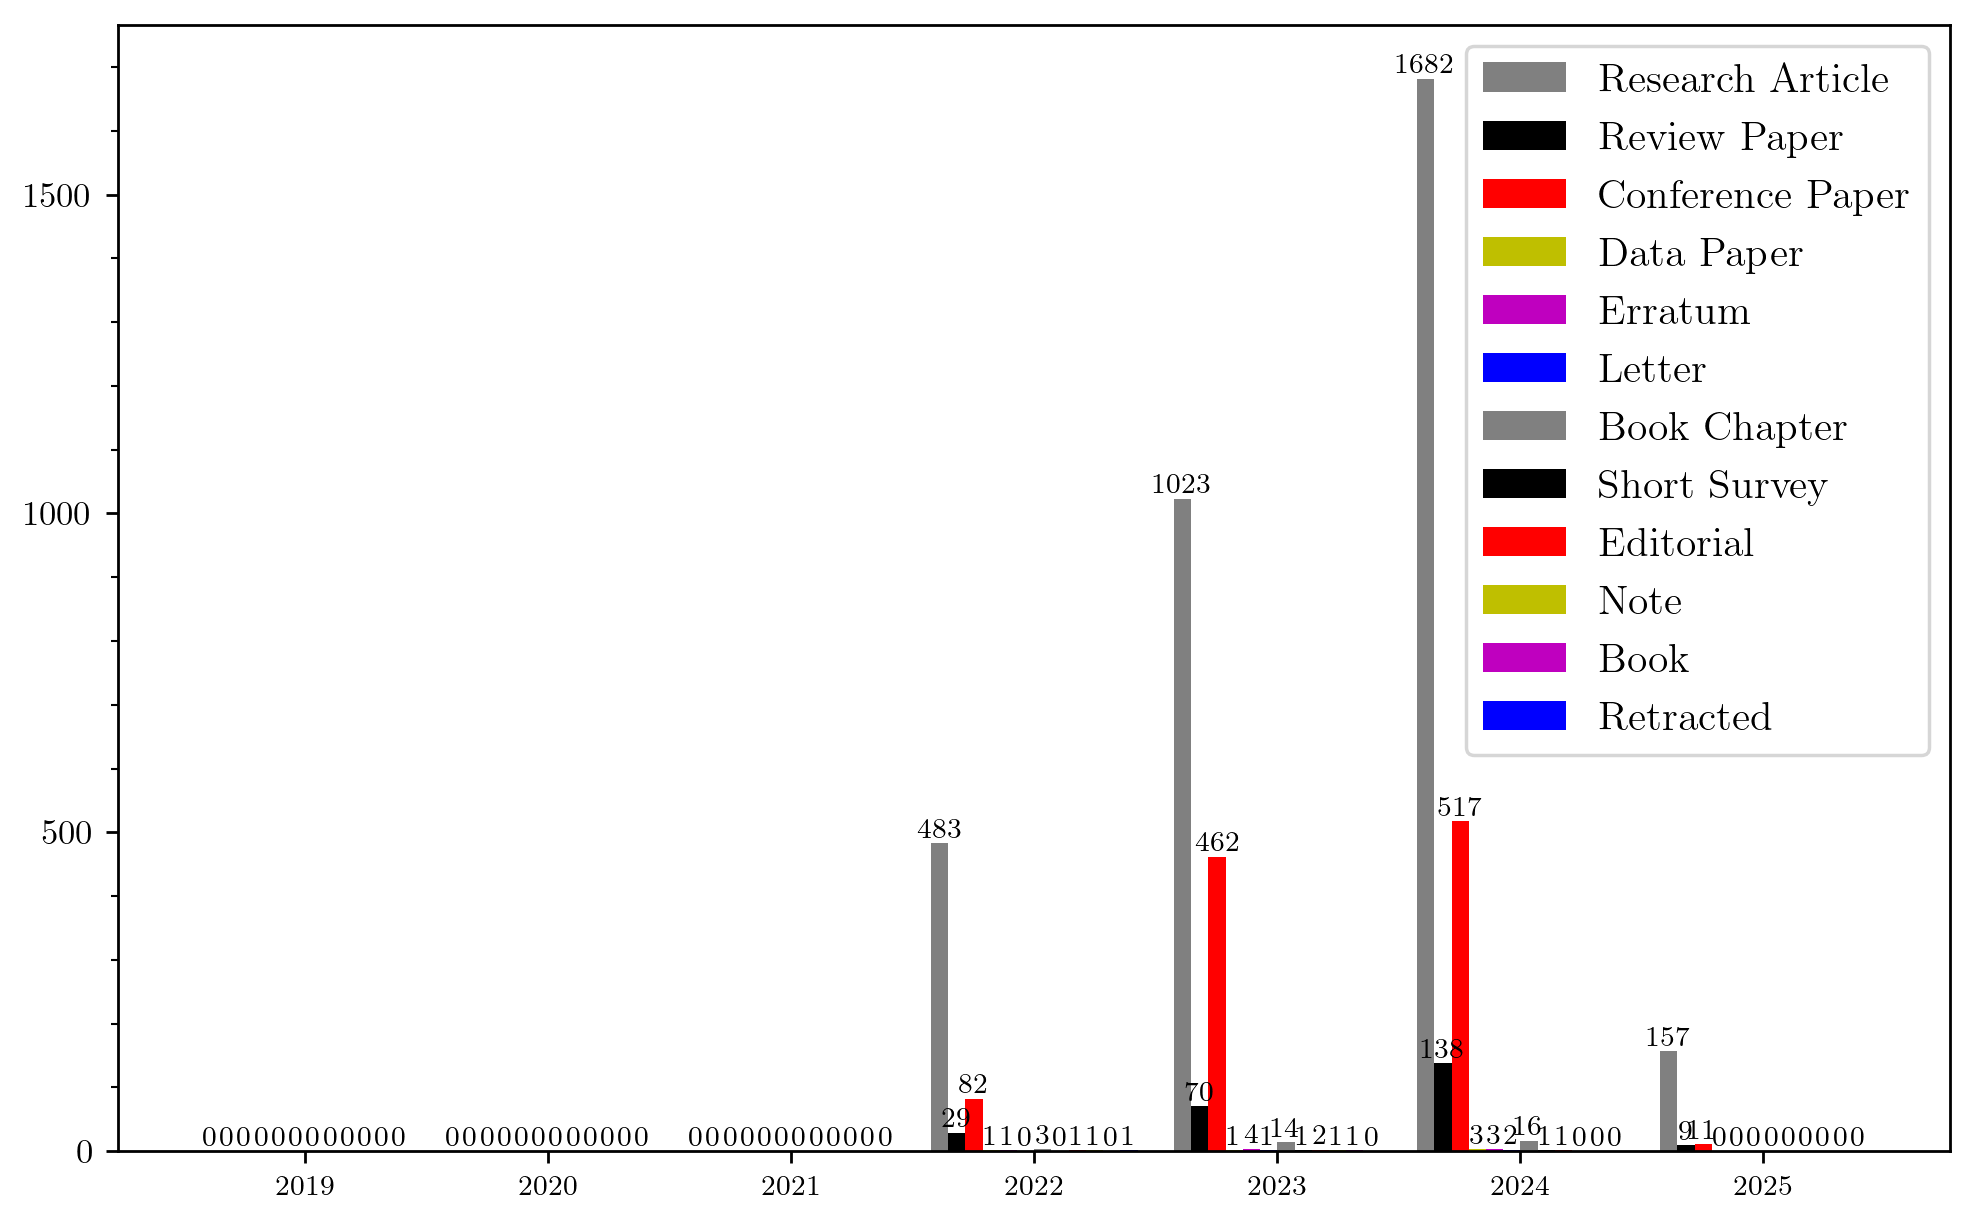

In [16]:
years = [i for i in range(2019, 2026)]
fontsize={'legend':12, 'text':8, 'labels':8, 'xticks':8}
article_types = df.article_type.unique()
results = []
data_publication_over_year = {}

for article_type in article_types:
    data_publication_over_year[article_type] = []
    for year in years:
        temp = df.loc[
            (df['year'] == year) & (df['article_type'] == article_type)]['title'].count()
        data_publication_over_year[article_type].append(temp)
        filtered_data = df.loc[
            (df['year'] == year) & (df['article_type'] == article_type)
        ]
        
        # Count the number of articles and collect titles
        count = filtered_data['title'].count()
        titles = filtered_data['title'].tolist()
        
        # Append a row to the results list
        results.append({
            'Article_Type': article_type,
            'Year': year,
            'Count': count,
            'Titles': '|'.join(titles)  # Concatenate titles into a single string
        })

subcategorybar(
    years, 
    [data_publication_over_year[article_type] for article_type in data_publication_over_year.keys()], 
    colors, 
    article_types,
    width=0.85, 
    major=500, 
    minor=100, 
    bar=True, 
    spines=True,
    show_text=True,
    rotation=0,
    fontsize=fontsize
)

results_df = pd.DataFrame(results)


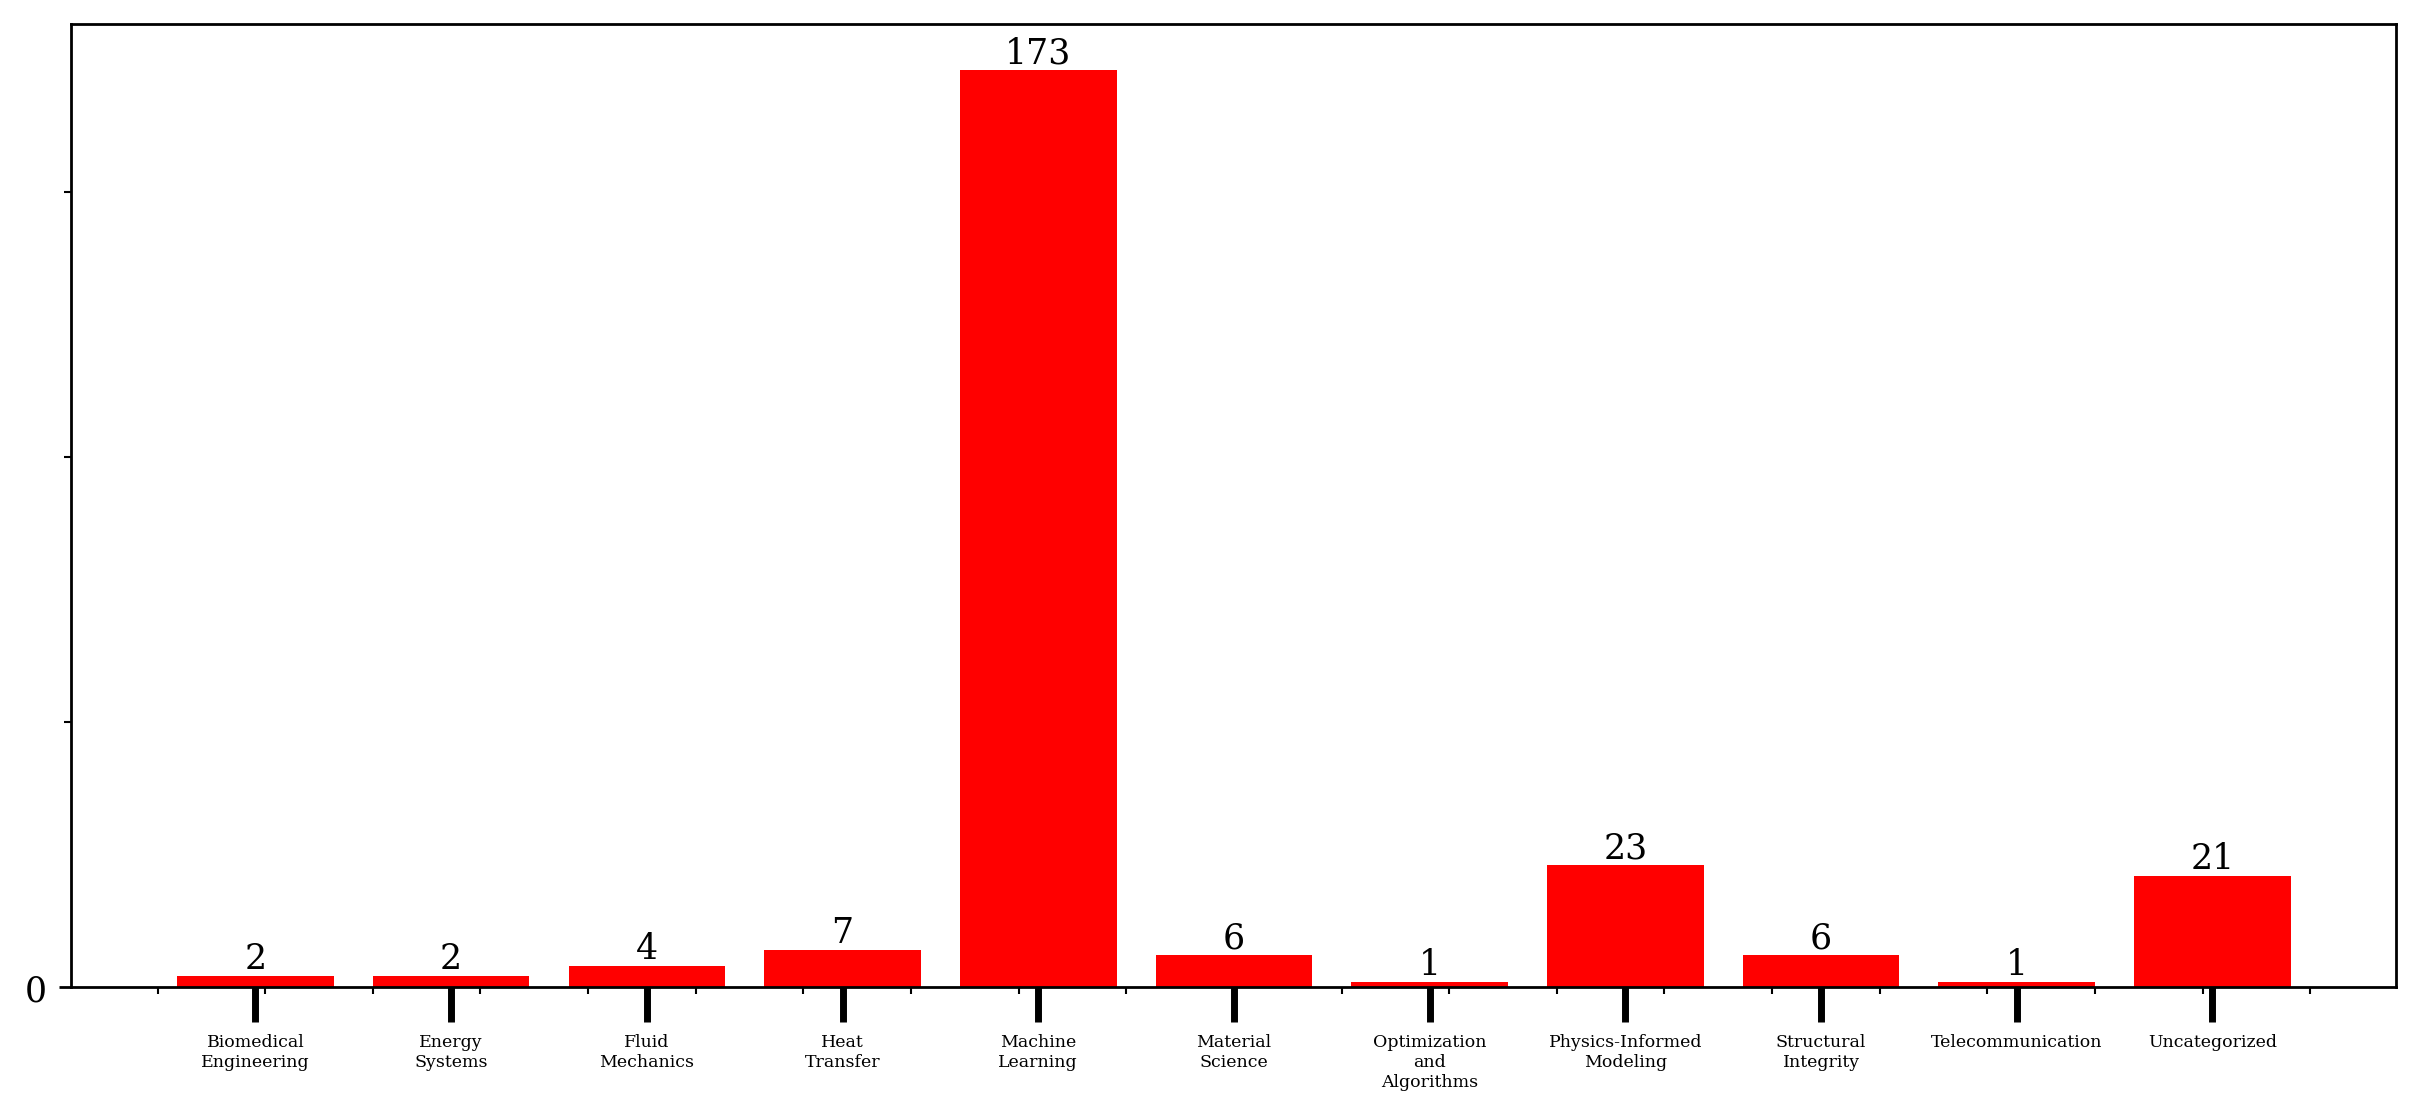

In [33]:
titles = df.loc[df.article_type == 'Review Paper']['title'].tolist()
properties = {
    'Heat Transfer': r'heat transfer|thermal|temperature|cooling|condensation',
    'Machine Learning': r'machine learning|deep learning|neural network|AI|artificial intelligence',
    'Physics-Informed Modeling': r'physics-informed|PINN|physics-driven',
    'Fluid Mechanics': r'fluid mechanics|CFD|aerodynamic|turbulence|hydrodynamics|rheology|microfluidic|Unsteady Secondary Flow|scramjet engine',
    'Material Science': r'materials|alloys|additive manufacturing|metals|composites|solid mechanics|porous',
    'Energy Systems': r'energy|battery|power systems|solar|wind|renewable',
    'Biomedical Engineering': r'biomedical|MRI|medical imaging|health|bioprocess|mechanobiology',
    'Environmental Science': r'environmental|soil|oceanography|climate|ecosystem',
    'Structural Integrity': r'structural integrity|reliability|fatigue|fracture|stability|structural|infrastructure',
    'Optimization and Algorithms': r'optimization|algorithms|metaheuristics|Bayesian',
    'Telecommunication': r'optic'
}

# Initialize a results dictionary
classified_titles = defaultdict(list)

# Classify titles based on properties
for title in titles:
    classified = False
    for key, pattern in properties.items():
        if re.search(pattern, title, re.IGNORECASE):  # Case-insensitive search
            classified_titles[key].append(title)
            classified = True
            break
    if not classified:  # Add to "Uncategorized" if no match
        classified_titles['Uncategorized'].append(title)

# Convert classified results into a DataFrame
classified_data = []
for category, title_list in classified_titles.items():
    for title in title_list:
        classified_data.append({'Category': category, 'Title': title})

classified_df = pd.DataFrame(classified_data)
property_df = classified_df.groupby(['Category']).count()
Y = property_df.Title.to_list()
X = property_df.index.to_list()
# Plotting
fig, ax = plt.subplots(figsize=(12, 5), dpi=250)
bars = ax.bar(
    X, 
    Y, 
    width=0.8, 
    color='r'
)

for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        yval + 0.1,  # Y position (slightly above the bar)
        round(yval, 2),  # The value of the bar, rounded to 2 decimals
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10  # Font size
    )

# Adjust x-axis labels
labels = [label.replace(' ', '\n') for label in X]
_X = np.arange(len(X))
plt.xticks(_X, labels, rotation=0, ha='center', fontsize=6)

# Set y-axis tick intervals
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(50))

ax.tick_params(axis='x', which='major', length=10, width=2, labelsize=5, rotation=0)
ax.set_xticks(range(len(X)))
ax.set_xticks(np.linspace(-0.5, len(X) - 0.5, 21), minor=True)

# Make right and top spines visible
ax.spines[['right', 'top']].set_visible(True)

plt.show()

In [36]:
df.loc[df.article_type == 'Review Paper']

,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,...,publish_date,publication_title,authors,affiliations,number_of_affiliations,countries,number_of_countries,number_of_found_property_group,number_of_found_properties,year
9,9,9,9,9,9,9,9,9,9,9,...,2025-03-01,Applied Energy,"Ma Zhihao,Jiang Gang,Hu Yuqing,Chen Jianli","(John and Marcia Price College of Engineering,...",4,"China,United States,United States,United States",4,0,0,2025
52,52,52,52,52,52,52,52,52,52,52,...,2025-02-01,Building and Environment,"Duran Ayca,Waibel Christoph,Piccioni Valeria,B...","(ETH Zürich,Zurich,Switzerland),(ETH Zürich,Zu...",5,"Switzerland,Switzerland,Switzerland,Switzerlan...",5,0,0,2025
57,57,57,57,57,57,57,57,57,57,57,...,2025-02-01,Current Opinion in Colloid and Interface Science,"Mangal Deepak,Jha Anushka,Dabiri Donya,Jamali ...","(College of Engineering,Boston,United States),...",4,"United States,United States,United States,Unit...",4,0,0,2025
80,80,80,80,80,80,80,80,80,80,80,...,2025-01-17,Journal of Manufacturing Processes,"Faegh Meysam,Ghungrad Suyog,Oliveira João Pedr...","(College of Engineering,Chicago,United States)...",5,"Portugal,United States,United States,United St...",5,0,0,2025
89,89,89,89,89,89,89,89,89,89,89,...,2025-01-15,Applied Energy,"Zhang Jiahao,Peng Ruo,Lu Chenbei,Wu Chenye","(The Chinese University of Hong Kong, Shenzhen...",4,"China,China,China,China",4,0,0,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4605,4605,4605,4605,4605,4605,4605,4605,4605,4605,4605,...,2022-03-01,Comprehensive Reviews in Food Science and Food...,"Khan Md Imran H.,Sablani Shyam S.,Nayak Richi,...","(Queensland University of Technology,Brisbane,...",4,"Australia,Australia,Australia,United States",4,2,0,2022
4608,4608,4608,4608,4608,4608,4608,4608,4608,4608,4608,...,2022-03-01,Physics of Fluids,"McConkey R.,Yee E.,Lien F. S.","(University of Waterloo,Waterloo,Canada),(Univ...",3,"Canada,Canada,Canada",3,0,0,2022
4609,4609,4609,4609,4609,4609,4609,4609,4609,4609,4609,...,2022-03-01,Bioengineering,"León Carlos,Melnik Roderick","(MS2Discovery Institute,Waterloo,Canada),(MS2D...",2,"Canada,Canada",2,0,0,2022
4612,4612,4612,4612,4612,4612,4612,4612,4612,4612,4612,...,2022-03-01,Advanced Materials Interfaces,"Diddens Diddo,Appiah Williams Agyei,Mabrouk Yo...","(Forschungszentrum Jülich GmbH,Julich,Germany)...",6,"Germany,Germany,Germany,Denmark,Denmark,Denmark",6,0,0,2022


In [34]:
classified_df.loc[classified_df.Category == 'Uncategorized']['Title'].to_list()

['An improved water strider algorithm for solving the inverse Burgers Huxley equation',
 'PineTree: A generative, fast, and differentiable halo model for wide-field galaxy surveys',
 'The Composition of Earth’s Lower Mantle',
 'Overview of Design Considerations for Data-Driven Time-Stepping Schemes Applied to Nonlinear Mechanical Systems',
 'Neural-Integrated Meshfree (NIM) Method: A differentiable programming-based hybrid solver for computational mechanics',
 'Ten years of generative adversarial nets (GANs): a survey of the state-of-the-art',
 'The P-DNS Method for Turbulent Fluid Flows: An Overview',
 'Accelerated simulation methodologies for computational vascular flow modelling',
 'Mixtures Recomposition by Neural Nets: A Multidisciplinary Overview',
 'Optimizing data-driven arctic marine forecasting: a comparative analysis of MariNet, FourCastNet, and PhyDNet',
 'State-of-the-Art Review on Determining One-Dimensional Consolidation Parameters Based on Compression and Distribution o

In [20]:
a = classified_df.groupby(['Category']).count()

C:\Users\user\AppData\Local\Temp\ipykernel_20700\2790839884.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_20700\2790839884.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_20700\2790839884.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_20700\2790839884.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mas

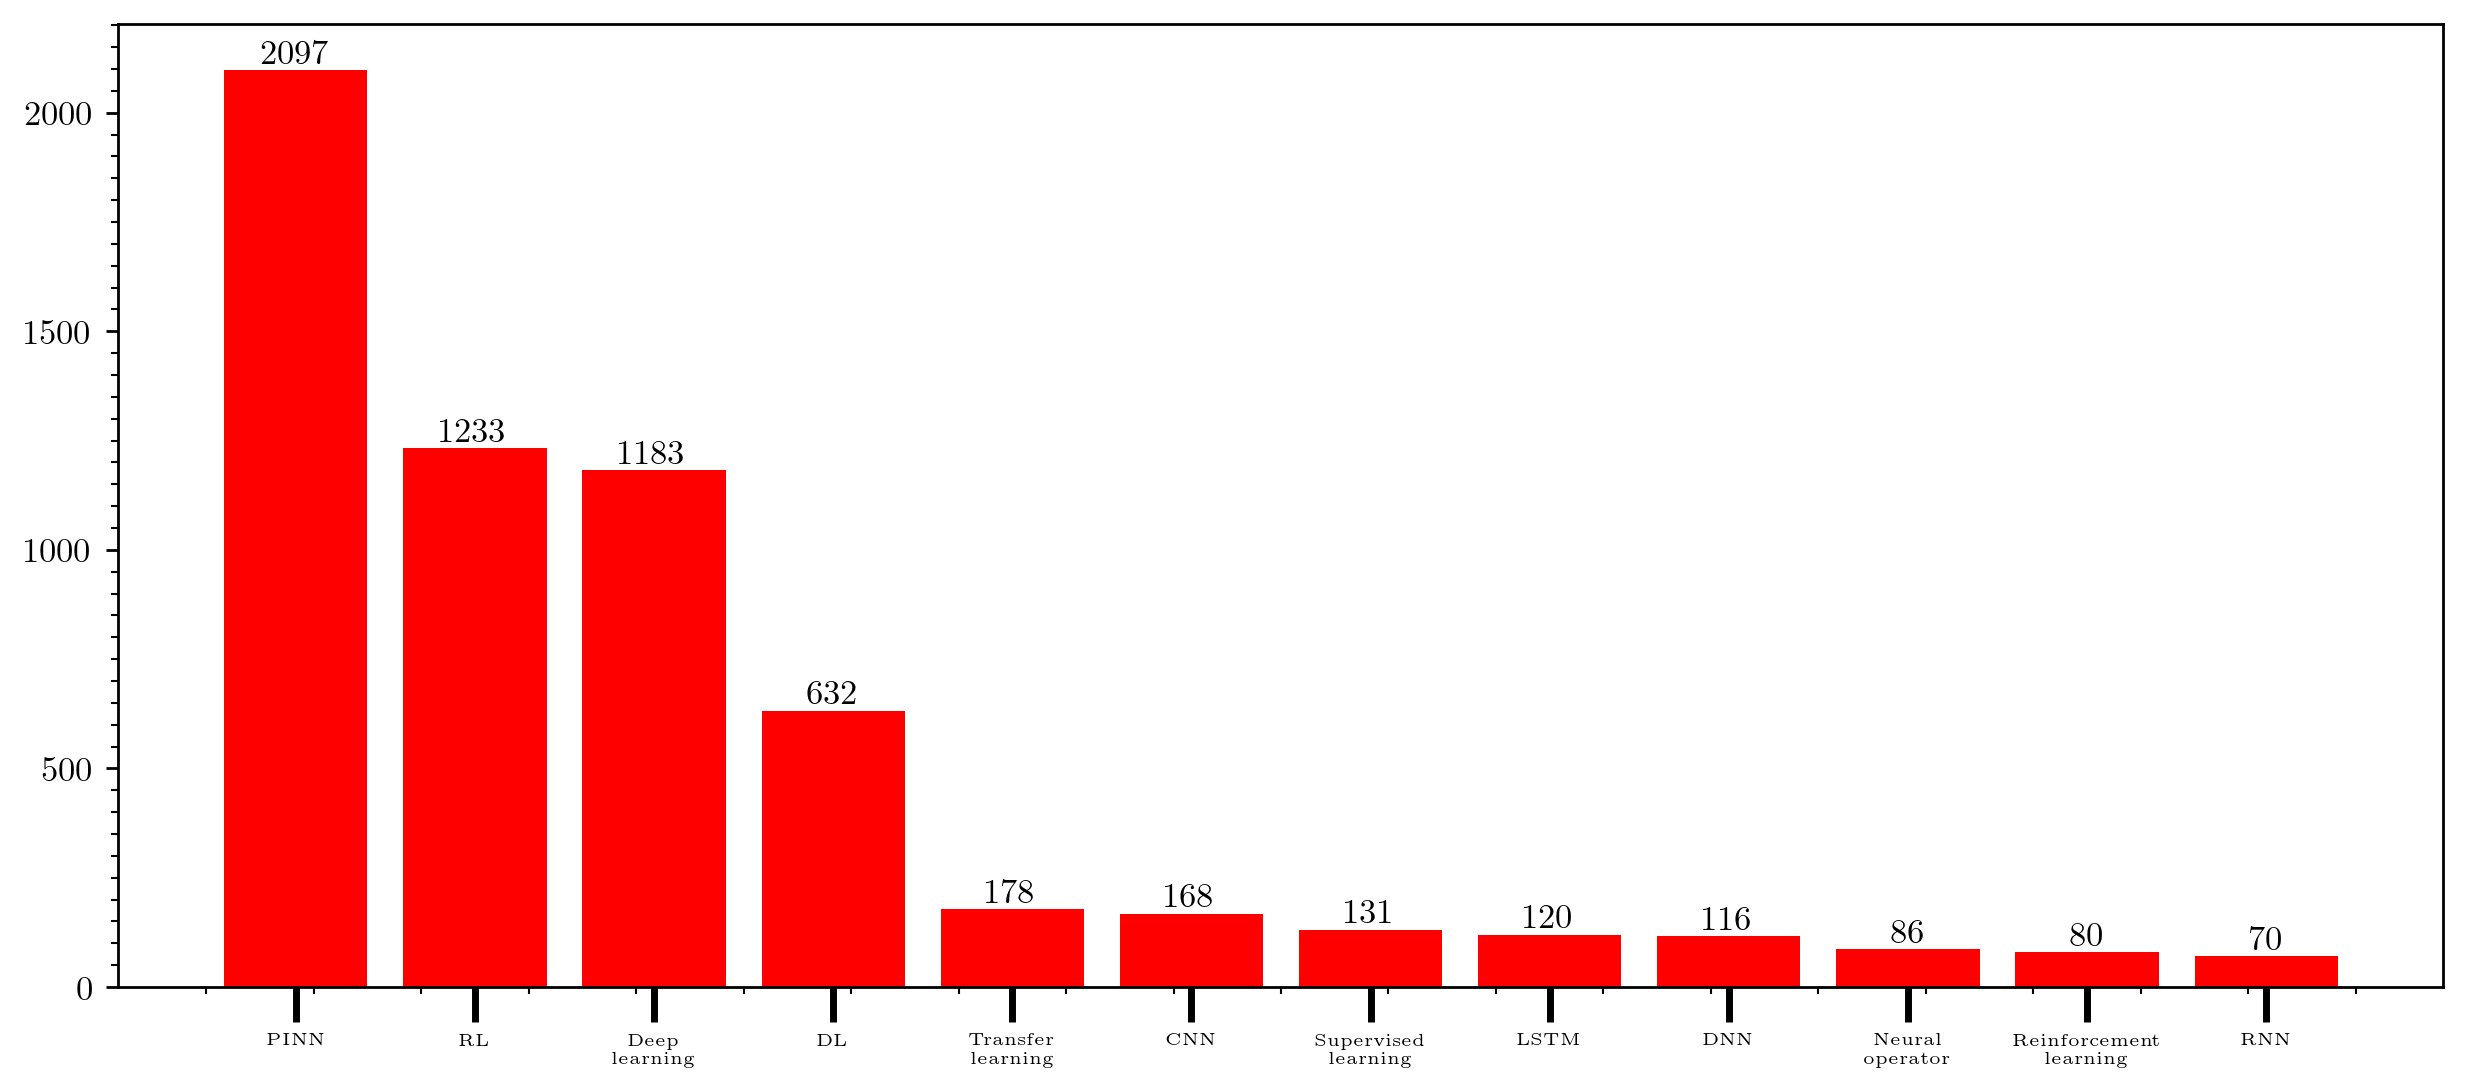

In [21]:
properties = [
    'DNN', 'RL', 'DRL', 'DL', 'Genetic Algorithm', 'LSTM', 'PINN', 'Physics-informed neural networks (PINN)', 'Neural operator', 'Fourier neural operator (FNO)', 'Gaussian processes', 'Reinforcement learning', 'Deep learning', 'Supervised learning', 'SVM' , 'CNN', 'RNN',
    'Unsupervised learning', 'Semi-supervised learning', 'GRU', 'GNN'
    'Autoencoders', 'Variational autoencoders (VAE)', 'Generative adversarial networks (GAN)',
    'Bayesian neural networks', 'Sparse regression', 'Symbolic regression',
    'Support vector machines (SVM)', 'Random forests', 'Gradient boosting',
    'Physics-constrained optimization',
    'Multi-task learning', 'Transfer learning', 'Meta-learning', 
    'Convolutional neural networks (CNN)', 'Recurrent neural networks (RNN)',
    'Long short-term memory (LSTM)', 'Transformers', 'Graph neural networks (GNN)',
    'Physics-guided loss functions', 'Regularization methods', 'Optimization algorithms',
    'Hyperparameter tuning', 'Monte Carlo methods', 'Markov chain Monte Carlo (MCMC)',
    'Probabilistic programming', 'Reinforcement learning for physical systems', 
    'Model-based reinforcement learning', 'Evolutionary algorithms',
    'Bayesian optimization', 'Differentiable programming', 'MLP', 'Causality'
    'Hybrid neural-symbolic learning', 'Active learning'
]

property_frequency = {prop: 0 for prop in properties}
property_titles = {prop: [] for prop in properties}

df_combined_text = (
    df['keyword'].fillna('').str.lower() + ' ' +
    df['title'].fillna('').str.lower() + ' ' +
    df['abstract'].fillna('').str.lower()
)

for prop in properties:
    mask = df_combined_text.str.contains(prop.lower(), case=False)
    property_frequency[prop] = mask.sum()
    property_titles[prop] = df.loc[mask, 'title'].tolist()

# Convert to DataFrame
property_df = pd.DataFrame({
    'Property': list(property_frequency.keys()),
    'Frequency': list(property_frequency.values()),
    'Titles': ['; '.join(titles) for titles in property_titles.values()]
})

# Sort by frequency and filter top 12
property_df = property_df.sort_values(by='Frequency', ascending=False)[:12]

# Plotting
fig, ax = plt.subplots(figsize=(12, 5), dpi=250)
bars = ax.bar(
    property_df['Property'], 
    property_df['Frequency'], 
    width=0.8, 
    color='r'
)

for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        yval + 0.1,  # Y position (slightly above the bar)
        round(yval, 2),  # The value of the bar, rounded to 2 decimals
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10  # Font size
    )

# Adjust x-axis labels
labels = [label.replace(' ', '\n') for label in property_df['Property']]
_X = np.arange(len(property_df['Property']))
plt.xticks(_X, labels, rotation=0, ha='center', fontsize=6)

# Set y-axis tick intervals
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(50))

ax.tick_params(axis='x', which='major', length=10, width=2, labelsize=5, rotation=0)
ax.set_xticks(range(len(property_df['Property'])))
ax.set_xticks(np.linspace(-0.5, len(property_df['Property']) - 0.5, 21), minor=True)

# Make right and top spines visible
ax.spines[['right', 'top']].set_visible(True)

plt.show()

In [22]:
property_df

,Property,Frequency,Titles
6,PINN,2097,Physics informed neural network modelling for ...
1,RL,1233,Physics informed neural network modelling for ...
12,Deep learning,1183,Investigating neural networks with groundwater...
3,DL,632,Personalized predictions of Glioblastoma infil...
31,Transfer learning,178,Higher-order multi-scale physics-informed neur...
15,CNN,168,Multi-fidelity physics-informed convolutional ...
13,Supervised learning,131,From PIV to LSPIV: Harnessing deep learning fo...
5,LSTM,120,Innovative optimization of hybrid energy stora...
0,DNN,116,Physics informed neural network modelling for ...
8,Neural operator,86,A practical existence theorem for reduced orde...


C:\Users\user\AppData\Local\Temp\ipykernel_20700\825515447.py:55: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_20700\825515447.py:55: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)


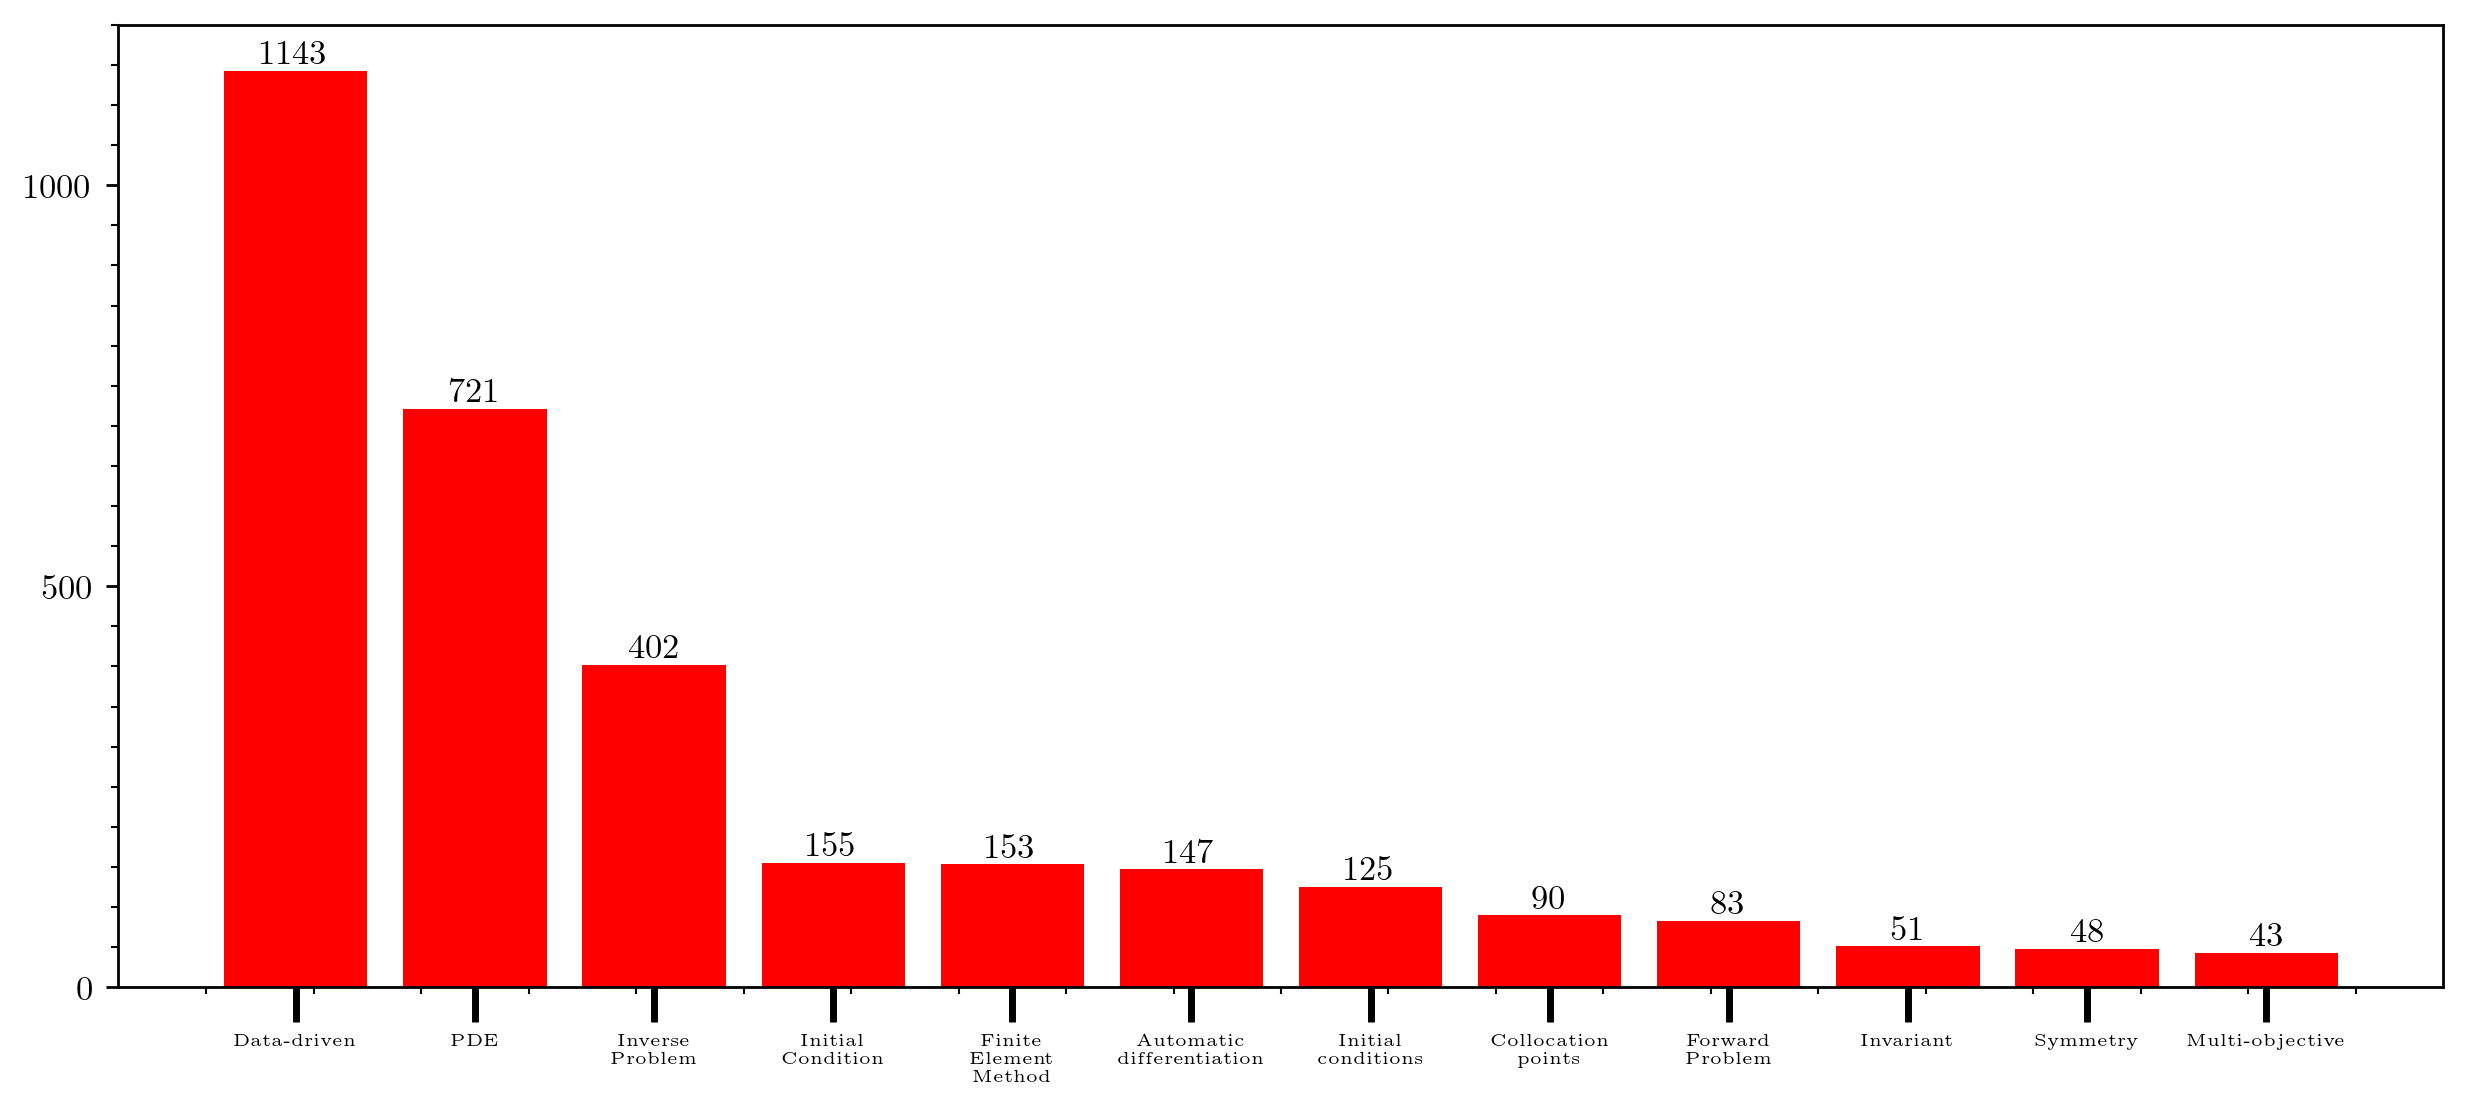

In [23]:
properties = [
        "Governing partial differential equations (PDEs)",
    "Boundary conditions (Dirichlet, Neumann, Robin)",
    "Initial conditions",
    
    # Loss Function Design
    "Physics-based loss",
    "Boundary condition loss",
    "Initial condition loss",
    "Total loss function",

    # Computational Techniques
    "Automatic differentiation",
    "Collocation points",
    "Regularization methods",
    
    # Advanced Techniques
    "Handling discontinuities",
    "High-dimensional PDEs",
    "Parameter inference",
    "Energy conservation",
    "Multi-fidelity learning",
    "Multi-scale resolution",
    
    # Interpretability and Uncertainty
    "Residual visualization",
    "Probabilistic PINNs",
    "Symmetry and invariance embedding",
    "Data-driven physics integration",
    "Reduce Order",
    "Forward Problem",
    "Inverse Problem",
    "Symmetry",
    "Invariant",
    "Equivariant",
    "Koopman",
    "Finite Element Method",
    "Data-driven",
    "Multi-objective",
    "PDE",
    "ODE"
    "Boundary Condition",
    "Initial Condition"
    ]
property_frequency = {prop: 0 for prop in properties}
property_titles = {prop: [] for prop in properties}

df_combined_text = (
    df['keyword'].fillna('').str.lower() + ' ' +
    df['title'].fillna('').str.lower() + ' ' +
    df['abstract'].fillna('').str.lower()
)

for prop in properties:
    mask = df_combined_text.str.contains(prop.lower(), case=False)
    property_frequency[prop] = mask.sum()
    property_titles[prop] = df.loc[mask, 'title'].tolist()

# Convert to DataFrame
property_df = pd.DataFrame({
    'Property': list(property_frequency.keys()),
    'Frequency': list(property_frequency.values()),
    'Titles': ['; '.join(titles) for titles in property_titles.values()]
})

# Sort by frequency and filter top 12
property_df = property_df.sort_values(by='Frequency', ascending=False)[:12]

# Plotting
fig, ax = plt.subplots(figsize=(12, 5), dpi=250)
bars = ax.bar(
    property_df['Property'], 
    property_df['Frequency'], 
    width=0.8, 
    color='r'
)

for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        yval + 0.1,  # Y position (slightly above the bar)
        round(yval, 2),  # The value of the bar, rounded to 2 decimals
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10  # Font size
    )

# Adjust x-axis labels
labels = [label.replace(' ', '\n') for label in property_df['Property']]
_X = np.arange(len(property_df['Property']))
plt.xticks(_X, labels, rotation=0, ha='center', fontsize=6)

# Set y-axis tick intervals
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(50))

ax.tick_params(axis='x', which='major', length=10, width=2, labelsize=5, rotation=0)
ax.set_xticks(range(len(property_df['Property'])))
ax.set_xticks(np.linspace(-0.5, len(property_df['Property']) - 0.5, 21), minor=True)

# Make right and top spines visible
ax.spines[['right', 'top']].set_visible(True)

plt.show()

In [24]:
property_df

,Property,Frequency,Titles
28,Data-driven,1143,Multi-fidelity physics-informed convolutional ...
30,PDE,721,Personalized predictions of Glioblastoma infil...
22,Inverse Problem,402,Personalized predictions of Glioblastoma infil...
32,Initial Condition,155,Inverse Physics-Informed Neural Networks for t...
27,Finite Element Method,153,Physics-Informed Extreme Learning Machine fram...
7,Automatic differentiation,147,Physics-Informed Extreme Learning Machine fram...
2,Initial conditions,125,Inverse Physics-Informed Neural Networks for t...
8,Collocation points,90,Impact of collocation point sampling technique...
21,Forward Problem,83,VW-PINNs: A volume weighting method for PDE re...
24,Invariant,51,Invariant deep neural networks under the finit...


C:\Users\user\AppData\Local\Temp\ipykernel_20700\3115614119.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_20700\3115614119.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)


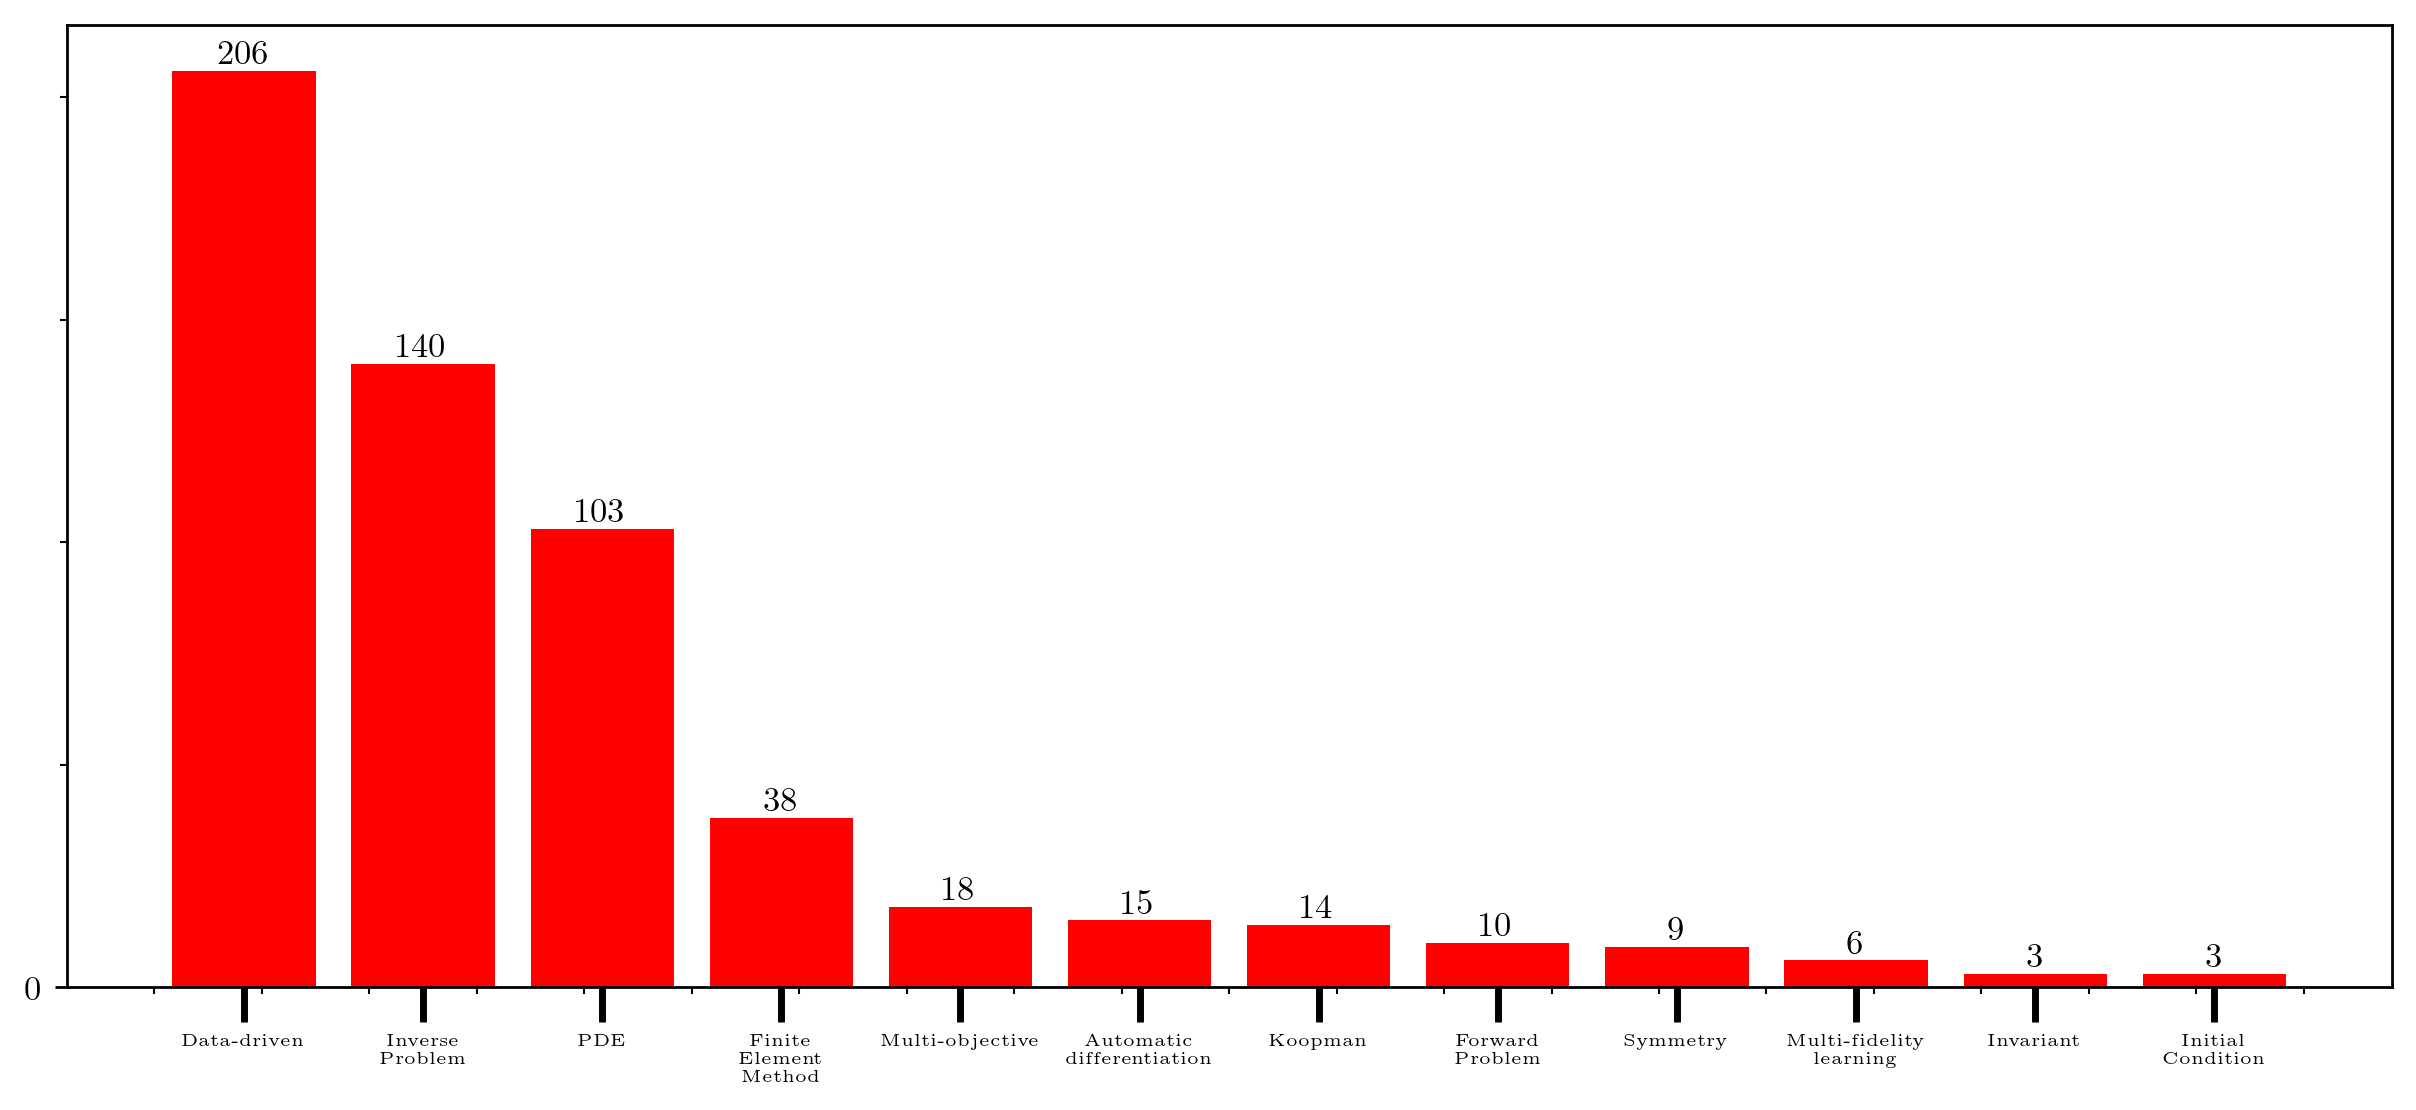

In [25]:
df_combined_text = (
    df['keyword'].fillna('').str.lower() + ' '
)

for prop in properties:
    mask = df_combined_text.str.contains(prop.lower(), case=False)
    property_frequency[prop] = mask.sum()
    property_titles[prop] = df.loc[mask, 'title'].tolist()

# Convert to DataFrame
property_df = pd.DataFrame({
    'Property': list(property_frequency.keys()),
    'Frequency': list(property_frequency.values()),
    'Titles': ['; '.join(titles) for titles in property_titles.values()]
})

# Sort by frequency and filter top 12
property_df = property_df.sort_values(by='Frequency', ascending=False)[:12]

# Plotting
fig, ax = plt.subplots(figsize=(12, 5), dpi=250)
bars = ax.bar(
    property_df['Property'], 
    property_df['Frequency'], 
    width=0.8, 
    color='r'
)

for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        yval + 0.1,  # Y position (slightly above the bar)
        round(yval, 2),  # The value of the bar, rounded to 2 decimals
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10  # Font size
    )

# Adjust x-axis labels
labels = [label.replace(' ', '\n') for label in property_df['Property']]
_X = np.arange(len(property_df['Property']))
plt.xticks(_X, labels, rotation=0, ha='center', fontsize=6)

# Set y-axis tick intervals
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(50))

ax.tick_params(axis='x', which='major', length=10, width=2, labelsize=5, rotation=0)
ax.set_xticks(range(len(property_df['Property'])))
ax.set_xticks(np.linspace(-0.5, len(property_df['Property']) - 0.5, 21), minor=True)

# Make right and top spines visible
ax.spines[['right', 'top']].set_visible(True)

plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_20700\1177496516.py:102: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_20700\1177496516.py:102: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_20700\1177496516.py:102: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)


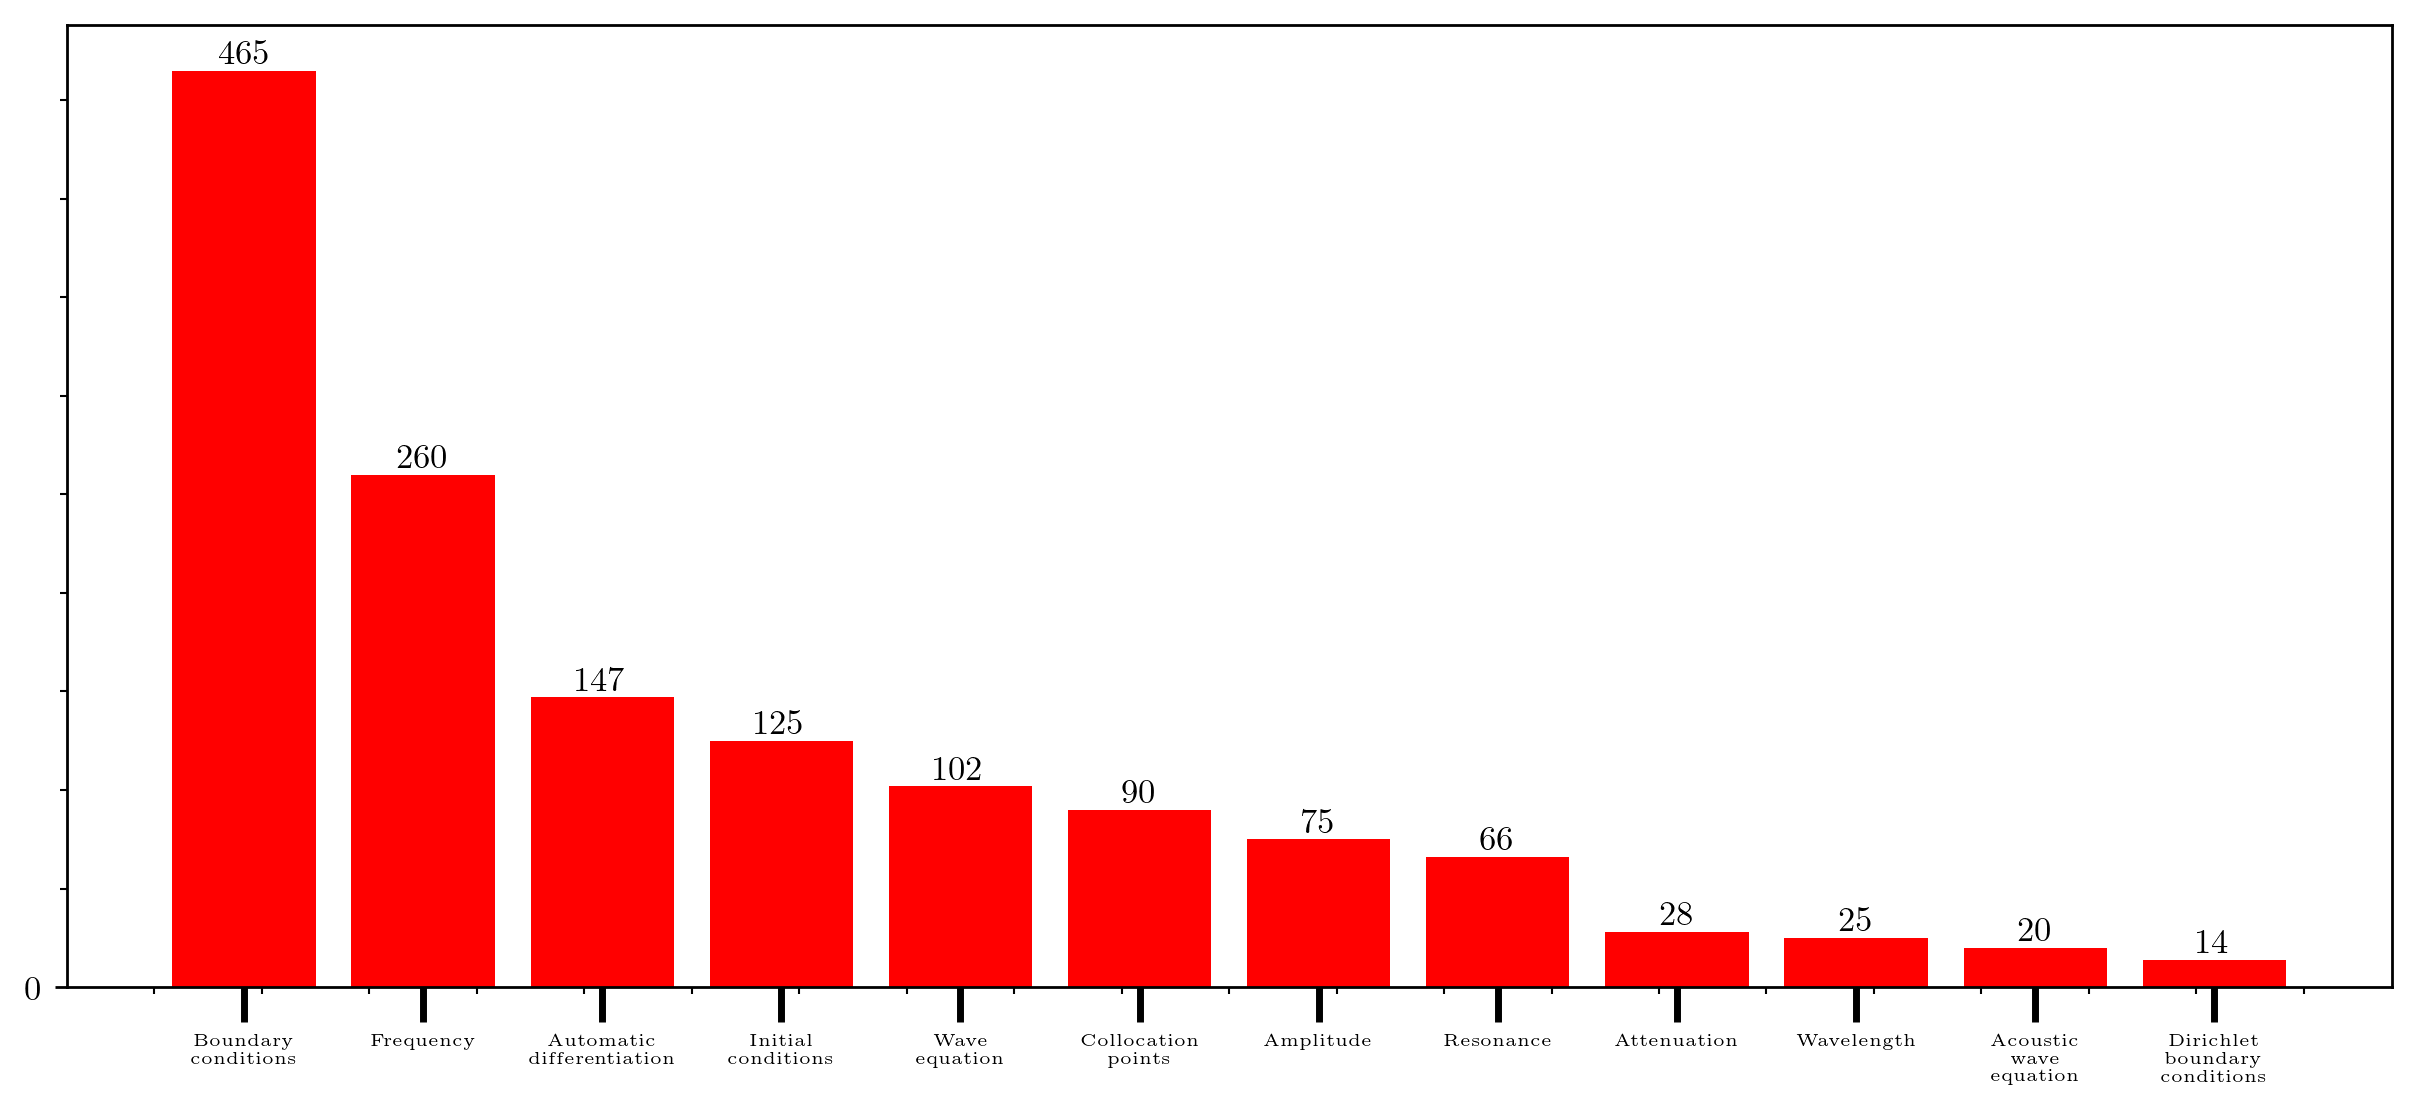

In [26]:
properties = [
    # Governing Equations
    "Wave equation",
    "Acoustic wave equation",
    "Elastic wave equation",
    "Seismic wave equation",
    "Electromagnetic wave equation",
    "Nonlinear wave equations",
    "Dispersion relations",

    # Initial and Boundary Conditions
    "Initial conditions",
    "Boundary conditions",
    "Dirichlet boundary conditions",
    "Neumann boundary conditions",
    "Robin boundary conditions",
    "Periodic boundary conditions",
    "Absorbing boundary conditions",
    "Perfectly Matched Layer (PML)",

    # Wave Characteristics
    "Wave velocity",
    "Phase velocity",
    "Group velocity",
    "Wavelength",
    "Frequency",
    "Amplitude",
    "Attenuation",
    "Reflection and transmission",
    "Scattering effects",
    "Wave interference",
    "Standing waves",
    "Resonance",
    "Stokes Wave",
    "Solitary Wave",

    # Computational Methods in PINNs
    "Collocation points",
    "Automatic differentiation",
    "Physics-based loss functions",
    "Residual minimization",
    "High-dimensional wave problems",
    "Handling discontinuities in waves",
    "Multi-fidelity learning",
    "Inverse modeling of wave parameters",
    "Source term identification",
    "Parameter inference for wave speed",

    # Mathematical Techniques
    "Fourier transforms",
    "Spectral methods",
    "Finite difference methods (FDM)",
    "Finite element methods (FEM)",
    "Rayleigh scattering",
    "Wave superposition principle",
    "Eigenvalue problems for waves",
    "Stability analysis of wave propagation",

    # Advanced PINN Topics
    "Symmetry and invariance in wave physics",
    "Energy conservation in wave propagation",
    "Data assimilation in PINNs",
    "Time-domain and frequency-domain analysis",
    "Multi-scale modeling of waves",
    "Harmonic analysis",
    "Domain decomposition for wave problems",
    "Sparse data reconstruction using PINNs",
    "Uncertainty quantification in wave PINNs",
    "Reduced-order modeling of wave systems",

    # Applications of Wave PINNs
    "Seismic wave modeling",
    "Acoustic wave propagation",
    "Electromagnetic wave analysis",
    "Water wave simulations",
    "Tsunami modeling",
    "Ultrasound imaging",
    "Vibration analysis in structures",
    "Non-destructive testing using waves",
    "Underwater acoustics",
    "Optical wave simulations",
    "Waveguide modeling",
    "Antenna design with wave PINNs",

    # Visualization and Diagnostics
    "Residual visualization",
    "Wavefront tracking",
    "Energy distribution plots",
    "Scattering pattern visualization",
    "Amplitude decay visualization"
]
property_frequency = {prop: 0 for prop in properties}
property_titles = {prop: [] for prop in properties}

df_combined_text = (
    df['keyword'].fillna('').str.lower() + ' ' +
    df['title'].fillna('').str.lower() + ' ' +
    df['abstract'].fillna('').str.lower()
)

for prop in properties:
    mask = df_combined_text.str.contains(prop.lower(), case=False)
    property_frequency[prop] = mask.sum()
    property_titles[prop] = df.loc[mask, 'title'].tolist()

# Convert to DataFrame
property_df = pd.DataFrame({
    'Property': list(property_frequency.keys()),
    'Frequency': list(property_frequency.values()),
    'Titles': ['; '.join(titles) for titles in property_titles.values()]
})

# Sort by frequency and filter top 12
property_df = property_df.sort_values(by='Frequency', ascending=False)[:12]

# Plotting
fig, ax = plt.subplots(figsize=(12, 5), dpi=250)
bars = ax.bar(
    property_df['Property'], 
    property_df['Frequency'], 
    width=0.8, 
    color='r'
)

for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        yval + 0.1,  # Y position (slightly above the bar)
        round(yval, 2),  # The value of the bar, rounded to 2 decimals
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10  # Font size
    )

# Adjust x-axis labels
labels = [label.replace(' ', '\n') for label in property_df['Property']]
_X = np.arange(len(property_df['Property']))
plt.xticks(_X, labels, rotation=0, ha='center', fontsize=6)

# Set y-axis tick intervals
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(50))

ax.tick_params(axis='x', which='major', length=10, width=2, labelsize=5, rotation=0)
ax.set_xticks(range(len(property_df['Property'])))
ax.set_xticks(np.linspace(-0.5, len(property_df['Property']) - 0.5, 21), minor=True)

# Make right and top spines visible
ax.spines[['right', 'top']].set_visible(True)

plt.show()

In [27]:
df['keyword'][0]

'Machine learning | Physical equation | Physics informed neural network | Storm surge'

C:\Users\user\AppData\Local\Temp\ipykernel_20700\3115614119.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_20700\3115614119.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)
C:\Users\user\AppData\Local\Temp\ipykernel_20700\3115614119.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df_combined_text.str.contains(prop.lower(), case=False)


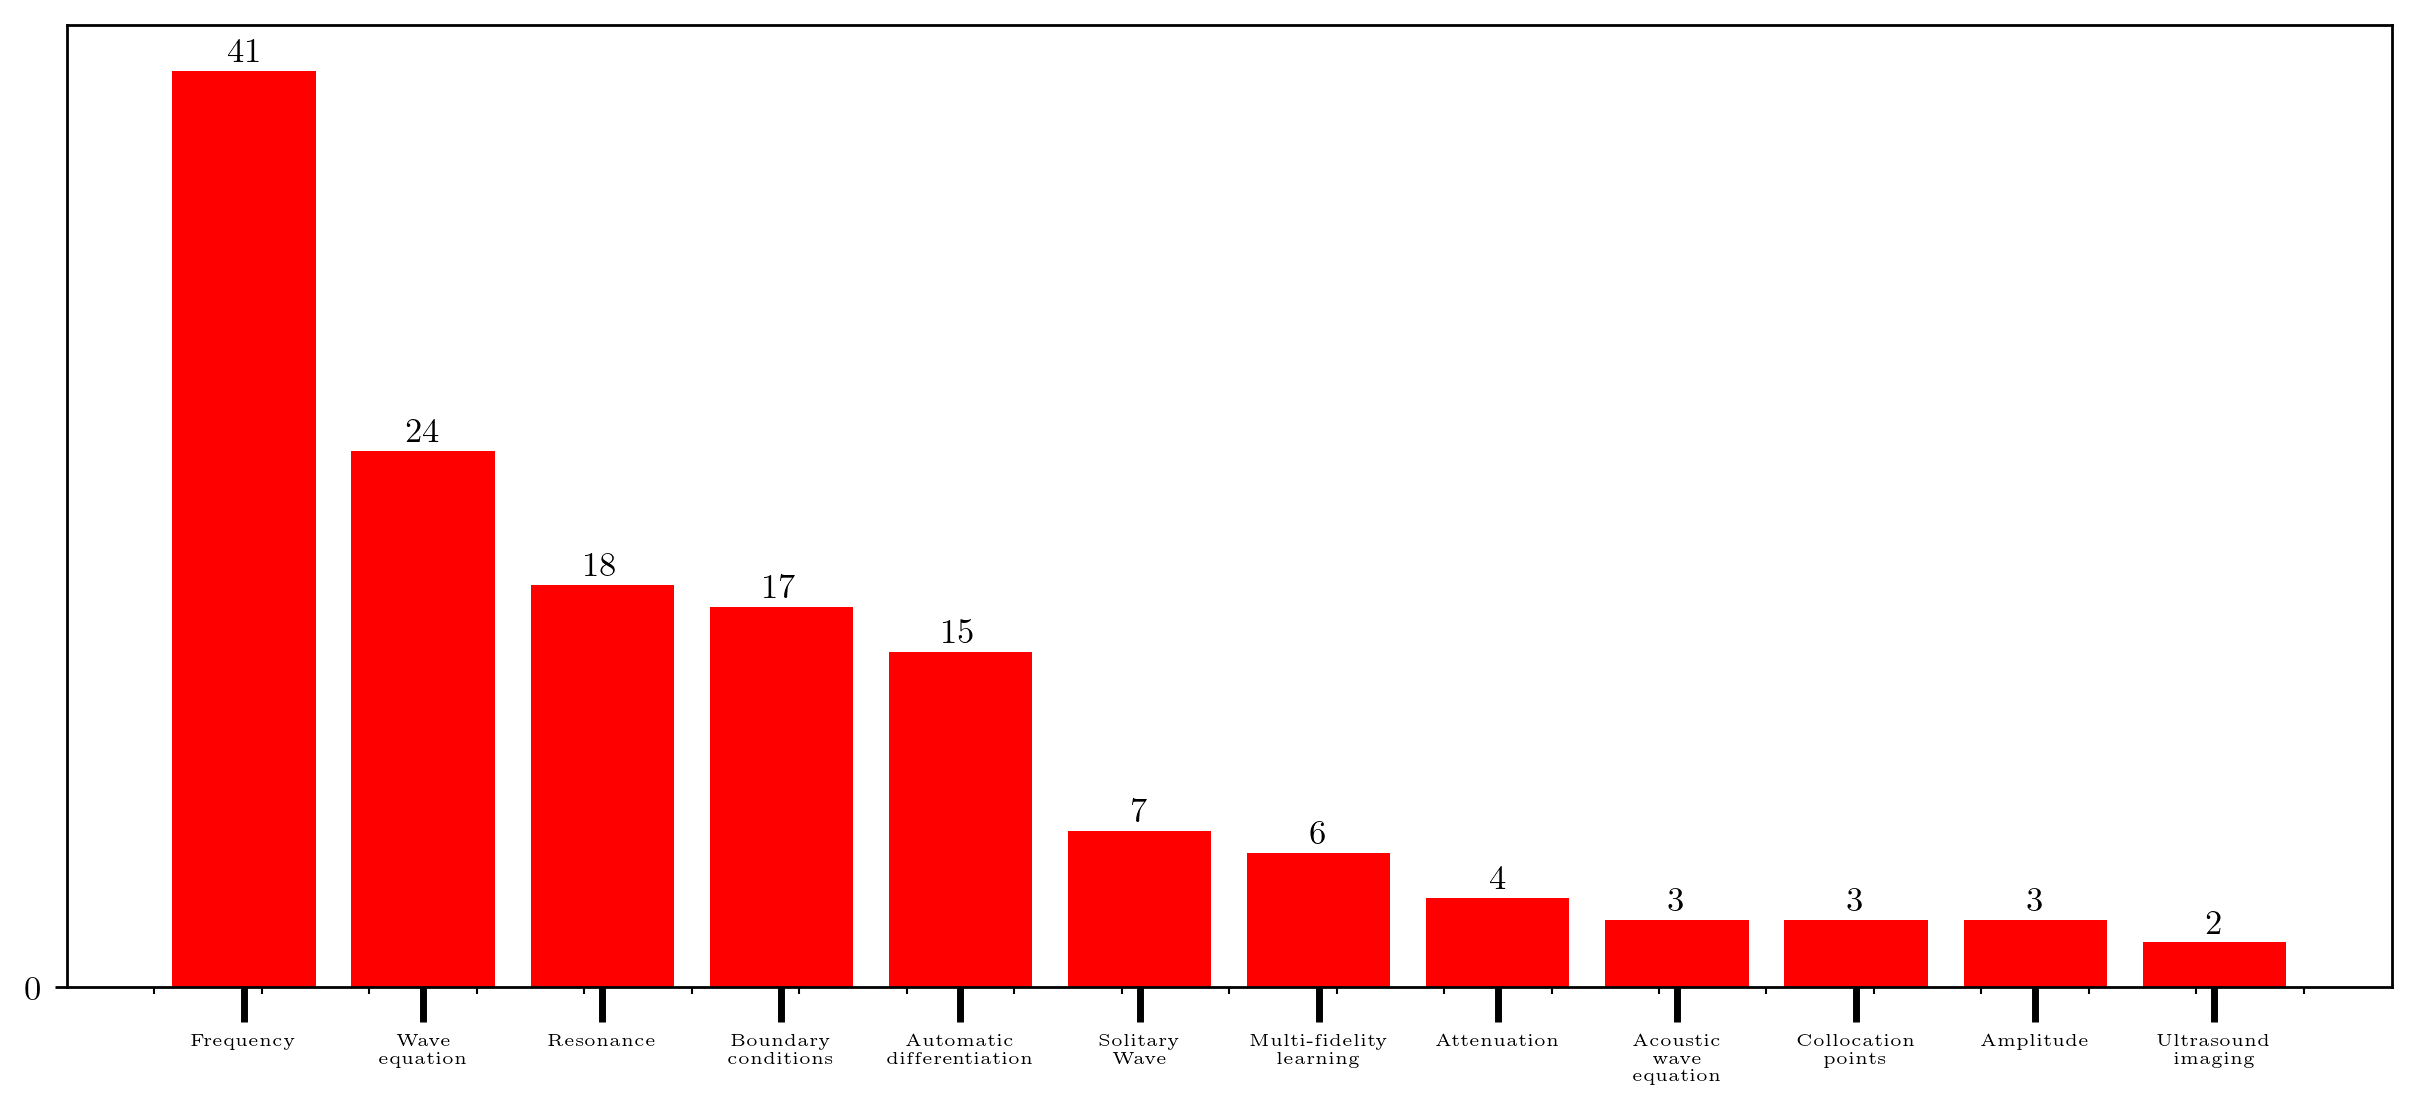

In [28]:
df_combined_text = (
    df['keyword'].fillna('').str.lower() + ' '
)

for prop in properties:
    mask = df_combined_text.str.contains(prop.lower(), case=False)
    property_frequency[prop] = mask.sum()
    property_titles[prop] = df.loc[mask, 'title'].tolist()

# Convert to DataFrame
property_df = pd.DataFrame({
    'Property': list(property_frequency.keys()),
    'Frequency': list(property_frequency.values()),
    'Titles': ['; '.join(titles) for titles in property_titles.values()]
})

# Sort by frequency and filter top 12
property_df = property_df.sort_values(by='Frequency', ascending=False)[:12]

# Plotting
fig, ax = plt.subplots(figsize=(12, 5), dpi=250)
bars = ax.bar(
    property_df['Property'], 
    property_df['Frequency'], 
    width=0.8, 
    color='r'
)

for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        yval + 0.1,  # Y position (slightly above the bar)
        round(yval, 2),  # The value of the bar, rounded to 2 decimals
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10  # Font size
    )

# Adjust x-axis labels
labels = [label.replace(' ', '\n') for label in property_df['Property']]
_X = np.arange(len(property_df['Property']))
plt.xticks(_X, labels, rotation=0, ha='center', fontsize=6)

# Set y-axis tick intervals
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(50))

ax.tick_params(axis='x', which='major', length=10, width=2, labelsize=5, rotation=0)
ax.set_xticks(range(len(property_df['Property'])))
ax.set_xticks(np.linspace(-0.5, len(property_df['Property']) - 0.5, 21), minor=True)

# Make right and top spines visible
ax.spines[['right', 'top']].set_visible(True)

plt.show()

In [29]:
' Neural network'.strip()

'Neural network'

In [30]:
all_keywords = []
for keywords in df['keyword']:
    all_keywords.extend([keyword.strip().lower() for keyword in keywords.split(' |')])

keyword_counts = Counter(all_keywords)

# Convert to a DataFrame for easier plotting
keyword_df = pd.DataFrame(keyword_counts.items(), columns=['Property', 'Frequency'])
keyword_df = keyword_df.sort_values(by='Frequency', ascending=False)
keyword_df.to_excel('Frequency keyword.xlsx', index=False)
keyword_df = keyword_df[:50]

In [31]:

plt.rc('text', usetex=False)
fig, ax = plt.subplots(figsize=(50, 10), dpi=500)
bars = ax.bar(
    keyword_df['Property'], 
    keyword_df['Frequency'], 
    width=0.8, 
    color='r'
)

for bar in bars:
    yval = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        yval + 0.1,  # Y position (slightly above the bar)
        round(yval, 2),  # The value of the bar, rounded to 2 decimals
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10  # Font size
    )

# Adjust x-axis labels
labels = [label.replace(' ', '\n') for label in keyword_df['Property']]
_X = np.arange(len(keyword_df['Property']))
plt.xticks(_X, labels, rotation=0, ha='center', fontsize=6)

# Set y-axis tick intervals
# ax.yaxis.set_major_locator(MultipleLocator(2.5))
# ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.tick_params(axis='x', which='major', length=10, width=2, labelsize=5, rotation=0)
ax.set_xticks(range(len(keyword_df['Property'])))
ax.set_xticks(np.linspace(-0.5, len(keyword_df['Property']) - 0.5, 21), minor=True)

# Make right and top spines visible
ax.spines[['right', 'top']].set_visible(True)

plt.show()

In [32]:
property_df

,Property,Frequency,Titles
19,Frequency,41,State of health estimation of lithium-ion batt...
0,Wave equation,24,Point neuron learning: a new physics-informed ...
26,Resonance,18,Integrating physics-informed machine learning ...
8,Boundary conditions,17,Groundwater inverse modeling: Physics-informed...
30,Automatic differentiation,15,Deep fuzzy physics-informed neural networks fo...
28,Solitary Wave,7,DEEP LEARNING FOR SOLITON DYNAMICS: A PHYSICS-...
35,Multi-fidelity learning,6,Neural network-augmented differentiable finite...
21,Attenuation,4,Neural network methods based on efficient opti...
1,Acoustic wave equation,3,Overcoming the Spectral Bias Problem of Physic...
29,Collocation points,3,Impact of collocation point sampling technique...
